## MIA FOR Finetuned LLM

### Variables and libraries

In [ ]:
# install the required libraries if you have not done so
!pip install -r requirements.txt

In [ ]:
import os, math, argparse
os.environ.setdefault("TRANSFORMERS_NO_TORCHVISION", "1")

import torch
import numpy as np
from datasets import load_from_disk
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.metrics import roc_auc_score, roc_curve, auc as _auc
import matplotlib.pyplot as plt
import json
from pathlib import Path
from datasets import Dataset

In [22]:
# global variable
target_model_dir = "./models/gpt2_phase1"
data_dir = "./data/wiki_json"
batch_size = 25

# you may change block size if you like (max length for the tokenizer below)
block_size = 128

### Data pre-processing 

In [3]:
def tokenize_dataset(ds, tok, max_len):
    ds = ds.filter(lambda ex: ex.get("text", None) and len(ex["text"].strip()) > 0)

    def _map(ex):
        out = tok(ex["text"], truncation=True, padding=True, max_length=max_len, return_attention_mask=True)
        out["labels"] = out["input_ids"].copy()
        return out

    ds = ds.map(_map, batched=True, remove_columns=ds.column_names)
    ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"]) 
    return ds

def _read_json(path: Path):
    with path.open("r", encoding="utf-8") as f:
        return json.load(f)

In [ ]:
# load test data
data_dir = Path(data_dir)
test_path = data_dir / "test.json"
test_items = _read_json(test_path)  
ds_test = Dataset.from_dict({"text": test_items})

# tokenizer the test data
tokenizer = AutoTokenizer.from_pretrained(target_model_dir, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side="right"

ds_test = tokenize_dataset(ds_test, tokenizer, block_size)
dl_test = DataLoader(ds_test, batch_size=batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# you may load the model using this in MIA
# model = AutoModelForCausalLM.from_pretrained(target_model_dir, dtype="auto").to(device)


Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

### MIA

In [ ]:
@torch.no_grad()
def your_attack(

):
    pass

scores_test = your_attack(...)

### Visualization

In [31]:
# load label to compute the performance, you will only have full access to it in phase 1 as a warm-up
label_path = data_dir / "test_label.json"
label_items = _read_json(label_path)

y_true = np.array(label_items)
scores = np.array(scores_test)
fpr, tpr, thr = roc_curve(y_true, scores)
auc_val = roc_auc_score(y_true, scores)
print(auc_val)

# some tpr fpr
print(max(tpr[fpr < 0.01])) # TPR @ 0.01FPR
print(max(tpr[fpr < 0.05])) # TPR @ 0.05FPR
# report this two metrics in your report!!

0.703916
0.035
0.173


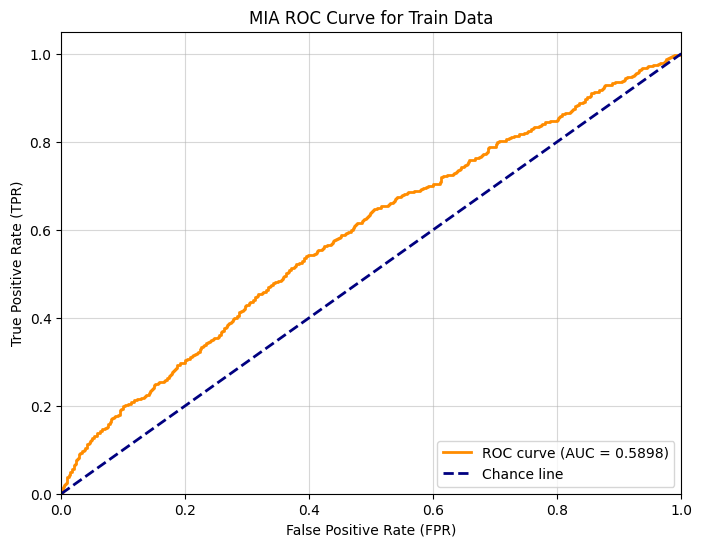

In [ ]:
# draw ROC curve and attach the figure in the report
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_val:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance line')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title(f'MIA ROC Curve for Train Data')
plt.legend(loc="lower right")
plt.grid(alpha=0.5)
plt.show()